## Analysis of Liquidators' Behavior in Lending Protocols

##### Introduction
In this analysis, I examined the behavior of liquidators across multiple lending protocols. The analysis covers data from five distinct lending 
protocols: zkLend, Nostra Alpha, Nostra Mainnet, Hashstack v0, and Hashstack v1.

##### Data SourcesIe utilized` event samples parquet`  from the following Google Storag link that was provided.


#### Data Processing
We consolidated data from all protocols into a single dataframe, adding a 'Protocol' column to distinguish events from different protocols.

###  Analysis and Visualization:

1. `Number of Liquidators per Protocol`: I counted the unique liquidators (from_address) for each protocol.
2. `Cross-Protocol Operations`: I identified liquidators operating across multiple protocols.
3. `Loans Liquidated by Each Liquidator`: I counted the number of loans liquidated by each liquidator.
4. `Amount of Liquidated Debt`: I computed the total and per-token amounts of liquidated debt.

I used Pandas, pandas as pd, pyarrow.parquet as pq, requests, matplotlib.pyplot as plt, seaborn as sns and io library to actualize the work.

ebt.


### Loading path for MySQL 

In [ ]:
import pandas as pd
import mysql.connector
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display  # Only needed for Jupyter Notebook

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='your_host',
    user='your_username',
    password='your_password',
    database='parquet_db'
)

# List of protocols (table names in the MySQL database)
protocols = ["zklend", "nostra_alpha", "nostra_mainnet", "hashstack_v0", "hashstack_v1"]

for protocol in protocols:
    print(f"Processing {protocol}...")
    
    # Query the data from the MySQL database
    query = f"SELECT * FROM {protocol}"
    df_ep = pd.read_sql_query(query, conn)
    
    pd.set_option('display.max_columns', None)  # Display all columns
    pd.set_option('display.max_colwidth', None)  # Display full column width
    pd.set_option('display.width', None)  # Adjust display width

    # Display the first rows
    display(df_ep.head())

# Close the connection
conn.close()

### Loading data from Google Storage 

In [1]:
import pandas as pd
import pyarrow.parquet as pq
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns
from io import BytesIO

# URLs of the events sample files for all lending protocols
parquet_urls = {
    "zklend": "https://storage.googleapis.com/derisk-persistent-state/zklend_data/events_sample.parquet",
    "nostra_alpha": "https://storage.googleapis.com/derisk-persistent-state/nostra_alpha_data/events_sample.parquet",
    "nostra_mainnet": "https://storage.googleapis.com/derisk-persistent-state/nostra_mainnet_data/events_sample.parquet",
    "hashstack_v0": "https://storage.googleapis.com/derisk-persistent-state/hashstack_v0_data/events_sample.parquet",
    "hashstack_v1": "https://storage.googleapis.com/derisk-persistent-state/hashstack_v1_data/events_sample.parquet"
}

dataframes_ep = {}

for protocol, url in parquet_urls.items():
    # Download the file
    response = requests.get(url)
    response.raise_for_status()  # Ensure the request was successful

    # Read the Parquet file into a Pandas DataFrame
    with BytesIO(response.content) as f:
        table = pq.read_table(f)
        df_ep = table.to_pandas()
    
    # Add a column for the protocol
    df_ep['Protocol'] = protocol
    
    # Store dataframe in dictionary
    dataframes_ep[protocol] = df_ep

In [2]:
# Combine all dataframes into a single dataframe
ep_data = pd.concat(dataframes_ep.values(), ignore_index=True)
ep_data.columns

Index(['block_hash', 'block_number', 'transaction_hash', 'event_index',
       'from_address', 'keys', 'data', 'timestamp', 'key_name', 'Protocol',
       'order'],
      dtype='object')

### Exploratory Data Analysis: 
***
We are going to Visualize the behavior of all liquidators found in our sample. We want to see the distribution of distributors accross different protocols

***

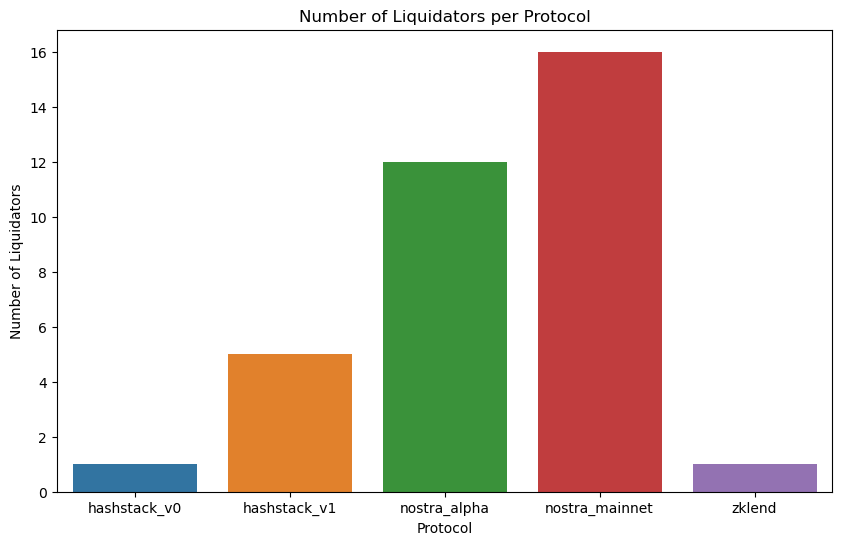

In [3]:
# Group by 'User' and 'Protocol' to get the number of liquidators per protocol
liquidators_per_protocol = ep_data.groupby('Protocol')['from_address'].nunique().reset_index()
liquidators_per_protocol.columns = ['Protocol', 'Number of Liquidators']

# Check if some liquidators operate on more than one protocol
multi_protocol_liquidators = ep_data.groupby('from_address')['Protocol'].nunique()
multi_protocol_liquidators = multi_protocol_liquidators[multi_protocol_liquidators > 1].count()

# Plot the number of liquidators per protocol
plt.figure(figsize=(10, 6))
sns.barplot(x='Protocol', y='Number of Liquidators', data=liquidators_per_protocol)
plt.title('Number of Liquidators per Protocol')
plt.xlabel('Protocol')
plt.ylabel('Number of Liquidators')
plt.show()

***
#### How many liquidators are there per protocol? 
***

In [4]:
# Display the liquidators per protocol table
print(liquidators_per_protocol)


         Protocol  Number of Liquidators
0    hashstack_v0                      1
1    hashstack_v1                      5
2    nostra_alpha                     12
3  nostra_mainnet                     16
4          zklend                      1



##### From the above output we can see that there different protocols here have different protocols.
##### hashstack_v0 has 1 hashstack_v1 5, nostra_alpha 12, nostra_mainnet 16 and zklend 1

***
#### Do some of the liquidator operate on more than just a single lending protocol?
***

In [5]:
# Check if some liquidators operate on more than one protocol
multi_protocol_liquidators = ep_data.groupby('from_address')['Protocol'].nunique()
multi_protocol_liquidators = (multi_protocol_liquidators > 1).sum()
multi_protocol_liquidators

0

##### From the Analysis above we can see that no liquidator operates on more than one lending protocol from the data in the database.

##### How did we arive at that? i was able to verify that by checking for through the `Procol` and the `from_address` columns.

In [ ]:
#

#### How many loans has each of them liquidated?

Here is a visualization to show how many loan each liquidatoe has liquidated. i went further to read it into a dataframe to capture the exact figures.

In [6]:
# Group by 'from_address' and count the number of unique loans liquidated by each liquidator
liquidators_loan_counts = ep_data.groupby('from_address')['transaction_hash'].nunique().reset_index()
liquidators_loan_counts.columns = ['Liquidator', 'Number of Loans Liquidated']
liquidators_loan_counts

,Liquidator,Number of Loans Liquidated
0,0x003cd2066f3c8b4677741b39db13acebba843bbbaa73...,31
1,0x005c4676bcb21454659479b3cd0129884d914df9c9b9...,610
2,0x00ba3037d968790ac486f70acaa9a1cab10cf5843bb8...,1212
3,0x012b8185e237dd0340340faeb3351dbe53f8a42f5a9b...,830
4,0x01ef7f9f8bf01678dc6d27e2c26fb7e8eac3812a2475...,992
5,0x021d8d8519f5464ec63c6b9a80a5229c5ddeed57ecde...,1476
6,0x024e9b0d6bc79e111e6872bb1ada2a874c25712cf08d...,374
7,0x02614c784267d2026042ab98588f90efbffaade89825...,102
8,0x029959a546dda754dc823a7b8aa65862c5825faeaaf7...,6323
9,0x0362b4455f5f4cc108a5a1ab1fd2cc6c4f0c70597abb...,2463


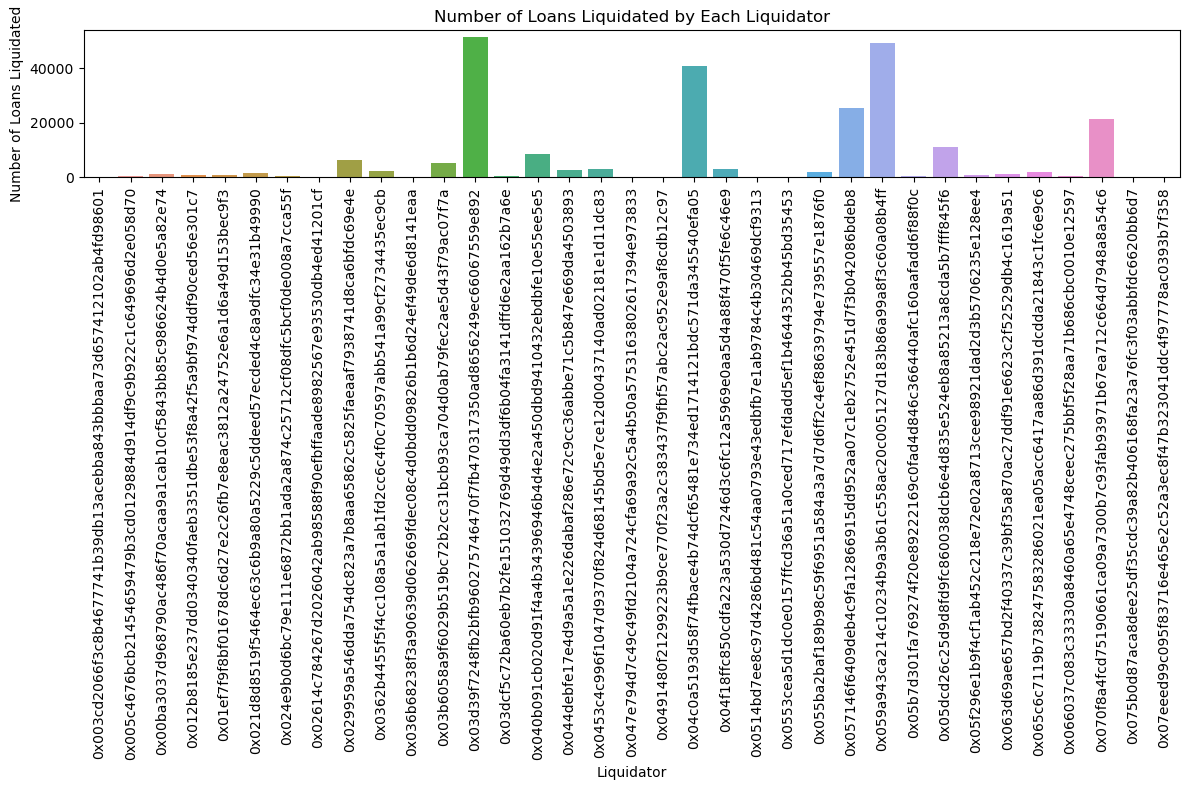

In [7]:
# Plot the number of loans liquidated by each liquidator
plt.figure(figsize=(12, 8))
sns.barplot(x='Liquidator', y='Number of Loans Liquidated', data=liquidators_loan_counts)
plt.title('Number of Loans Liquidated by Each Liquidator')
plt.xlabel('Liquidator')
plt.ylabel('Number of Loans Liquidated')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

***
### What was the amount of the liquidated debt?
Let's dive in and find out.
***

In [8]:
df_ep.columns

Index(['block_hash', 'block_number', 'transaction_hash', 'event_index',
       'from_address', 'keys', 'data', 'timestamp', 'key_name', 'order',
       'Protocol'],
      dtype='object')

In [9]:
len(["0x1","0x251e01d33f75076732f5c7c671d1e6918f3cd0f36a4dedcc35e642297f30d2a","0x12b8185e237dd0340340faeb3351dbe53f8a42f5a9bf974ddf90ced56e301c7",
     "0x44aa20","0x0","0x68f5c6a61780768455de69077e07e89787839bf8166decfbf92b645209c0fb8","0x44aa20","0x0","0x1","0x0","0x0","0x65168edf","0x1",
     "0x5fa6cc6185eab4b0264a4134e2d4e74be11205351c7c91196cb27d5d97f8d21","0x1e8480","0x0","0x65168edf","0x65168edf"])

18

In [10]:
df_ep['data'][0]

b'["0x1","0x251e01d33f75076732f5c7c671d1e6918f3cd0f36a4dedcc35e642297f30d2a","0x12b8185e237dd0340340faeb3351dbe53f8a42f5a9bf974ddf90ced56e301c7","0x44aa20","0x0","0x68f5c6a61780768455de69077e07e89787839bf8166decfbf92b645209c0fb8","0x44aa20","0x0","0x1","0x0","0x0","0x65168edf","0x1","0x5fa6cc6185eab4b0264a4134e2d4e74be11205351c7c91196cb27d5d97f8d21","0x1e8480","0x0","0x65168edf","0x65168edf"]'

In [11]:
import ast 
# Function to decode byte strings if needed
def decode_byte_string(value):
    if isinstance(value, bytes):
        return value.decode("utf-8")
    return value

# Decode and convert row function
def decode_and_convert_row(row):
    # Decode 'keys' and 'data' fields
    keys_decoded = decode_byte_string(row['keys'])
    data_decoded = decode_byte_string(row['data'])
    
    # Convert string representation of list to actual list
    keys = ast.literal_eval(keys_decoded)
    data = ast.literal_eval(data_decoded)
    
    # Function to convert hexadecimal string to integer
    def hex_to_int(hex_str):
        try:
            return int(hex_str, 16)
        except ValueError:
            return hex_str
    
    # Extract and structure the information
    standardized_row = {
        'block_hash': row['block_hash'],
        'block_number': row['block_number'],
        'transaction_hash': row['transaction_hash'],
        'event_index': row['event_index'],
        'timestamp': row['timestamp'],
        'from_address': row['from_address'],
        'event_type': row['key_name'],
        'token': keys[0] if keys else None,
        'amount': hex_to_int(data[1]) if data else None
    }
    
    return standardized_row

# Apply the function to each row
standardized_rows = df_ep.apply(decode_and_convert_row, axis=1)
standardized_df = pd.DataFrame(standardized_rows.tolist())

# Display the standardized DataFrame
standardized_df

,block_hash,block_number,transaction_hash,event_index,timestamp,from_address,event_type,token,amount
0,0x068b04151068a7acc1f72c9b2023e176037cb6bce171...,273262,0x0676e3ae850f6fae3da1269b9c390f74c26eb1948ca2...,21,1695977183,0x012b8185e237dd0340340faeb3351dbe53f8a42f5a9b...,new_loan,0x18b6525ecb6302165c034d5ae6831237f6b0e92fb512...,1049287087906382421176709442090370420132268470...
1,0x06c263286120af7afb020f535cd53e17da319df84350...,273300,0x06ebb5723abf3878214b66bd4bbe7087280707da7231...,9,1695977763,0x01ef7f9f8bf01678dc6d27e2c26fb7e8eac3812a2475...,new_loan,0x18b6525ecb6302165c034d5ae6831237f6b0e92fb512...,1049287087906382421176709442090370420132268470...
2,0x07d0f1faf834b7906e4de54c440d0aa35112bc1a243c...,273372,0x0051f75ef1e08f70d1c8efe7866384d026aa0ca092de...,25,1695978978,0x012b8185e237dd0340340faeb3351dbe53f8a42f5a9b...,loan_spent,0x8ec0ef7812932198b471e7a74f46d868b2d6f5ffabde...,1049287087906382421176709442090370420132268470...
3,0x06f650deb66bb602f02bd87f29aa7c28909b126f9d7c...,273387,0x01bf0af4c1922e2b8cc523e6e088d72885701e941605...,12,1695979201,0x012b8185e237dd0340340faeb3351dbe53f8a42f5a9b...,collateral_added,0x3a0bcdfe321e4020189044810e380d888ac9a9efcb48...,2704026738352261115367466080255332588141346582...
4,0x06384cf4b11477d048623b43e45970c5a4a106537065...,273396,0x0389888c9ef7dfe1491a3d15afa79b565bc52dccb01d...,0,1695979342,0x012b8185e237dd0340340faeb3351dbe53f8a42f5a9b...,collateral_added,0x3a0bcdfe321e4020189044810e380d888ac9a9efcb48...,2704026738352261115367466080255332588141346582...
...,...,...,...,...,...,...,...,...,...
4248,0x0636645121a647181fb5cf8c8c0d711d3b8ec215b947...,644532,0x004d06b9b82e9085b72277e8925cda336ad80245872a...,14,1716975796,0x021d8d8519f5464ec63c6b9a80a5229c5ddeed57ecde...,loan_spent,0x8ec0ef7812932198b471e7a74f46d868b2d6f5ffabde...,1977818563175329230280666044563219029086931155...
4249,0x07effca02bf20e4507cd4a87169fde845f728bd998c1...,644567,0x070d6757cb75909e17adc918a4f475afa20c14282a19...,10,1716988813,0x01ef7f9f8bf01678dc6d27e2c26fb7e8eac3812a2475...,new_loan,0x18b6525ecb6302165c034d5ae6831237f6b0e92fb512...,1039834440859670666001981052330907828042091977...
4250,0x04c9e7ed78d0a27a1c61a4fa17685b938fde07bda990...,644574,0x052a3efe1dd8334815b06428d3e492701d322895c0b7...,14,1716991344,0x01ef7f9f8bf01678dc6d27e2c26fb7e8eac3812a2475...,loan_spent,0x8ec0ef7812932198b471e7a74f46d868b2d6f5ffabde...,1039834440859670666001981052330907828042091977...
4251,0x02ae4e562ebc9ff895829db75f4417f6d611521939f5...,644577,0x057d280974f534b3e33286e8c8ec9d973775b57e774f...,16,1716992447,0x01ef7f9f8bf01678dc6d27e2c26fb7e8eac3812a2475...,loan_spent,0x8ec0ef7812932198b471e7a74f46d868b2d6f5ffabde...,1039834440859670666001981052330907828042091977...


In [12]:
standardized_df.columns

Index(['block_hash', 'block_number', 'transaction_hash', 'event_index',
       'timestamp', 'from_address', 'event_type', 'token', 'amount'],
      dtype='object')

In [13]:
standardized_df['amount']

0       1049287087906382421176709442090370420132268470...
1       1049287087906382421176709442090370420132268470...
2       1049287087906382421176709442090370420132268470...
3       2704026738352261115367466080255332588141346582...
4       2704026738352261115367466080255332588141346582...
                              ...                        
4248    1977818563175329230280666044563219029086931155...
4249    1039834440859670666001981052330907828042091977...
4250    1039834440859670666001981052330907828042091977...
4251    1039834440859670666001981052330907828042091977...
4252    1039834440859670666001981052330907828042091977...
Name: amount, Length: 4253, dtype: object

In [14]:
# Convert the 'amount' column to numeric (int)
standardized_df['amount'] = standardized_df['amount'].apply(int)


In [15]:
# Compute the total liquidated debt
total_liquidated_debt = standardized_df['amount'].sum()
print(f'Total Liquidated Debt: {total_liquidated_debt}')

Total Liquidated Debt: 7532758980090056521012464717000133223421175474566365733879104317408705477217160


In [16]:
standardized_df['token'].unique()

array(['0x18b6525ecb6302165c034d5ae6831237f6b0e92fb51211e90fb6acfc25d9249',
       '0x8ec0ef7812932198b471e7a74f46d868b2d6f5ffabde2a939963cdd7160287',
       '0x3a0bcdfe321e4020189044810e380d888ac9a9efcb48f653e30f24019bf00b1',
       '0xddf7098d85b93435e424bbeddf75431c723b0194566b9990225de37d2e9c52',
       '0x3aae3c57e97c0f2812edd7e8363de4fce5b229e0f188f12eeabd860ea338497'],
      dtype=object)

In [17]:
# Compute the total liquidated debt per token
total_liquidated_debt_per_token = standardized_df.groupby('token')['amount'].sum().reset_index()
total_liquidated_debt_per_token.columns = ['token', 'total_amount']
total_liquidated_debt_per_token


,token,total_amount
0,0x18b6525ecb6302165c034d5ae6831237f6b0e92fb512...,2605254899245682410888282189040604106282923174...
1,0x3a0bcdfe321e4020189044810e380d888ac9a9efcb48...,9637499492386421320532387811304500669141035203...
2,0x3aae3c57e97c0f2812edd7e8363de4fce5b229e0f188...,9185491586722912265585595877950634773568745130...
3,0x8ec0ef7812932198b471e7a74f46d868b2d6f5ffabde...,2477709677996174041603562352532283285472284221...
4,0xddf7098d85b93435e424bbeddf75431c723b0194566b...,2261564492057106732659440338534694477238870275...


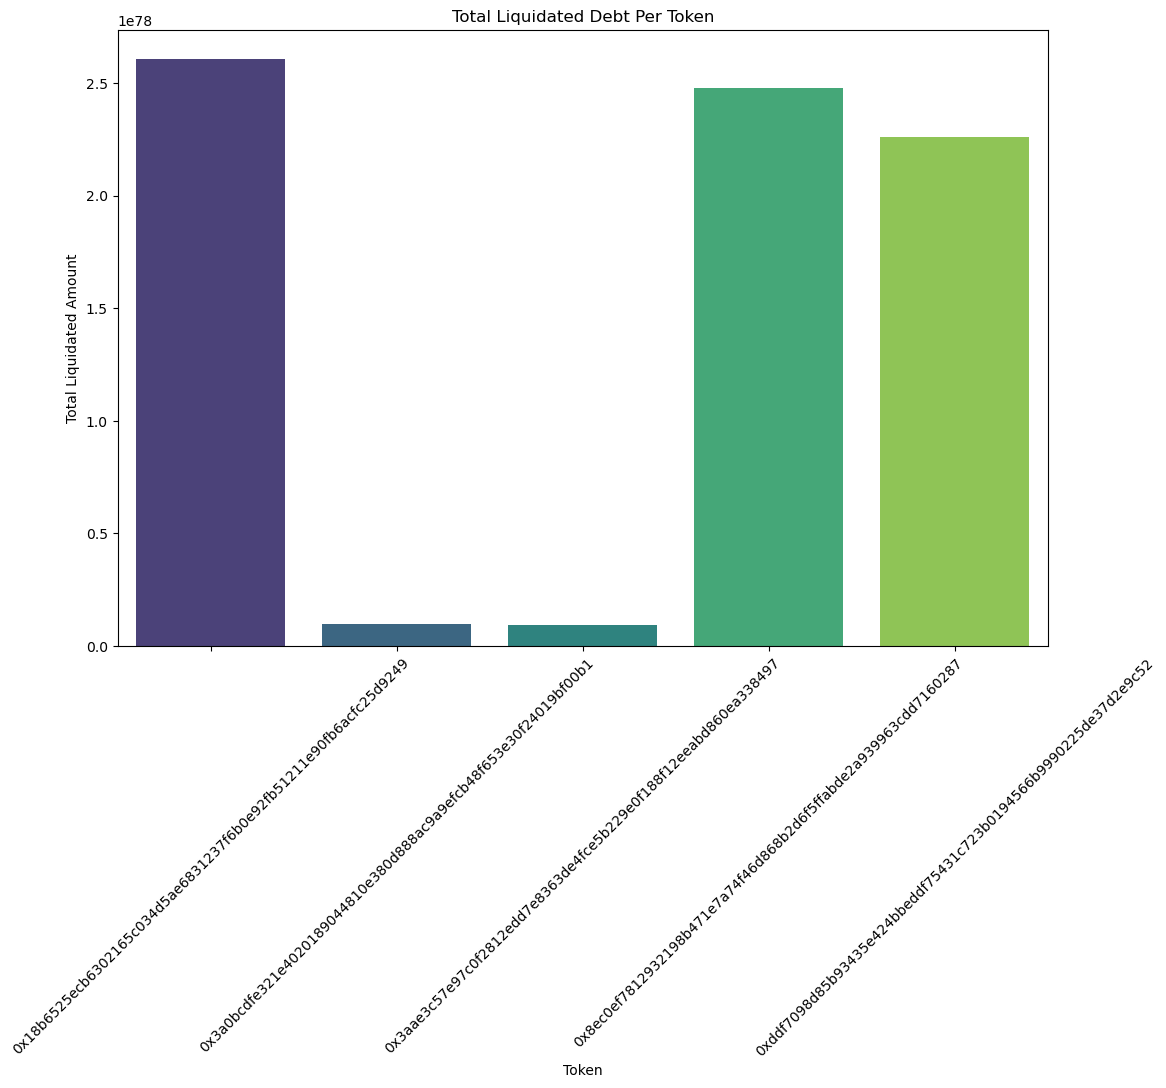

In [18]:
# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Bar plot for total liquidated debt per token
sns.barplot(data=total_liquidated_debt_per_token, x='token', y='total_amount', palette='viridis')

# Add titles and labels
plt.title('Total Liquidated Debt Per Token')
plt.xlabel('Token')
plt.ylabel('Total Liquidated Amount')
plt.xticks(rotation=45)
plt.show()

C:\Users\maseglo.com\Documents\Python Scripts\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


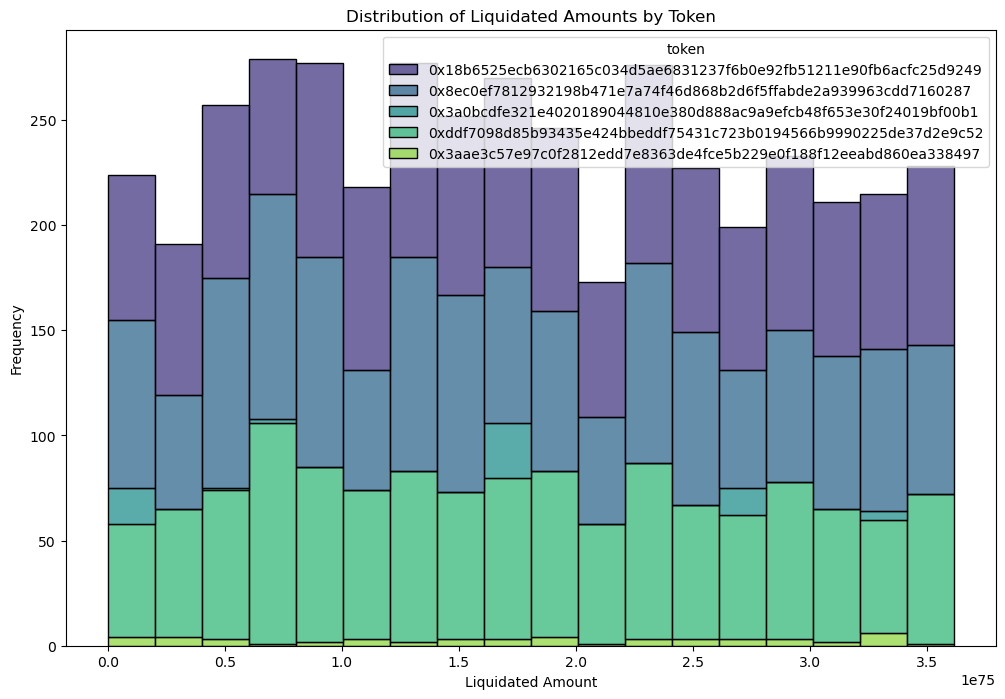

In [19]:
# Visualizing the behavior of all liquidators
plt.figure(figsize=(12, 8))
sns.histplot(data=standardized_df, x='amount', hue='token', multiple='stack', palette='viridis')

# Add titles and labels
plt.title('Distribution of Liquidated Amounts by Token')
plt.xlabel('Liquidated Amount')
plt.ylabel('Frequency')
plt.show()
